In [1]:
import thesis

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

plt.style.use("../../thesis-style.mpl")

In [2]:
import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
#sys.path.insert(0, "../../..")
import pymc3 as pm

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd

In [4]:
hills = pd.read_csv("arrochar.csv")

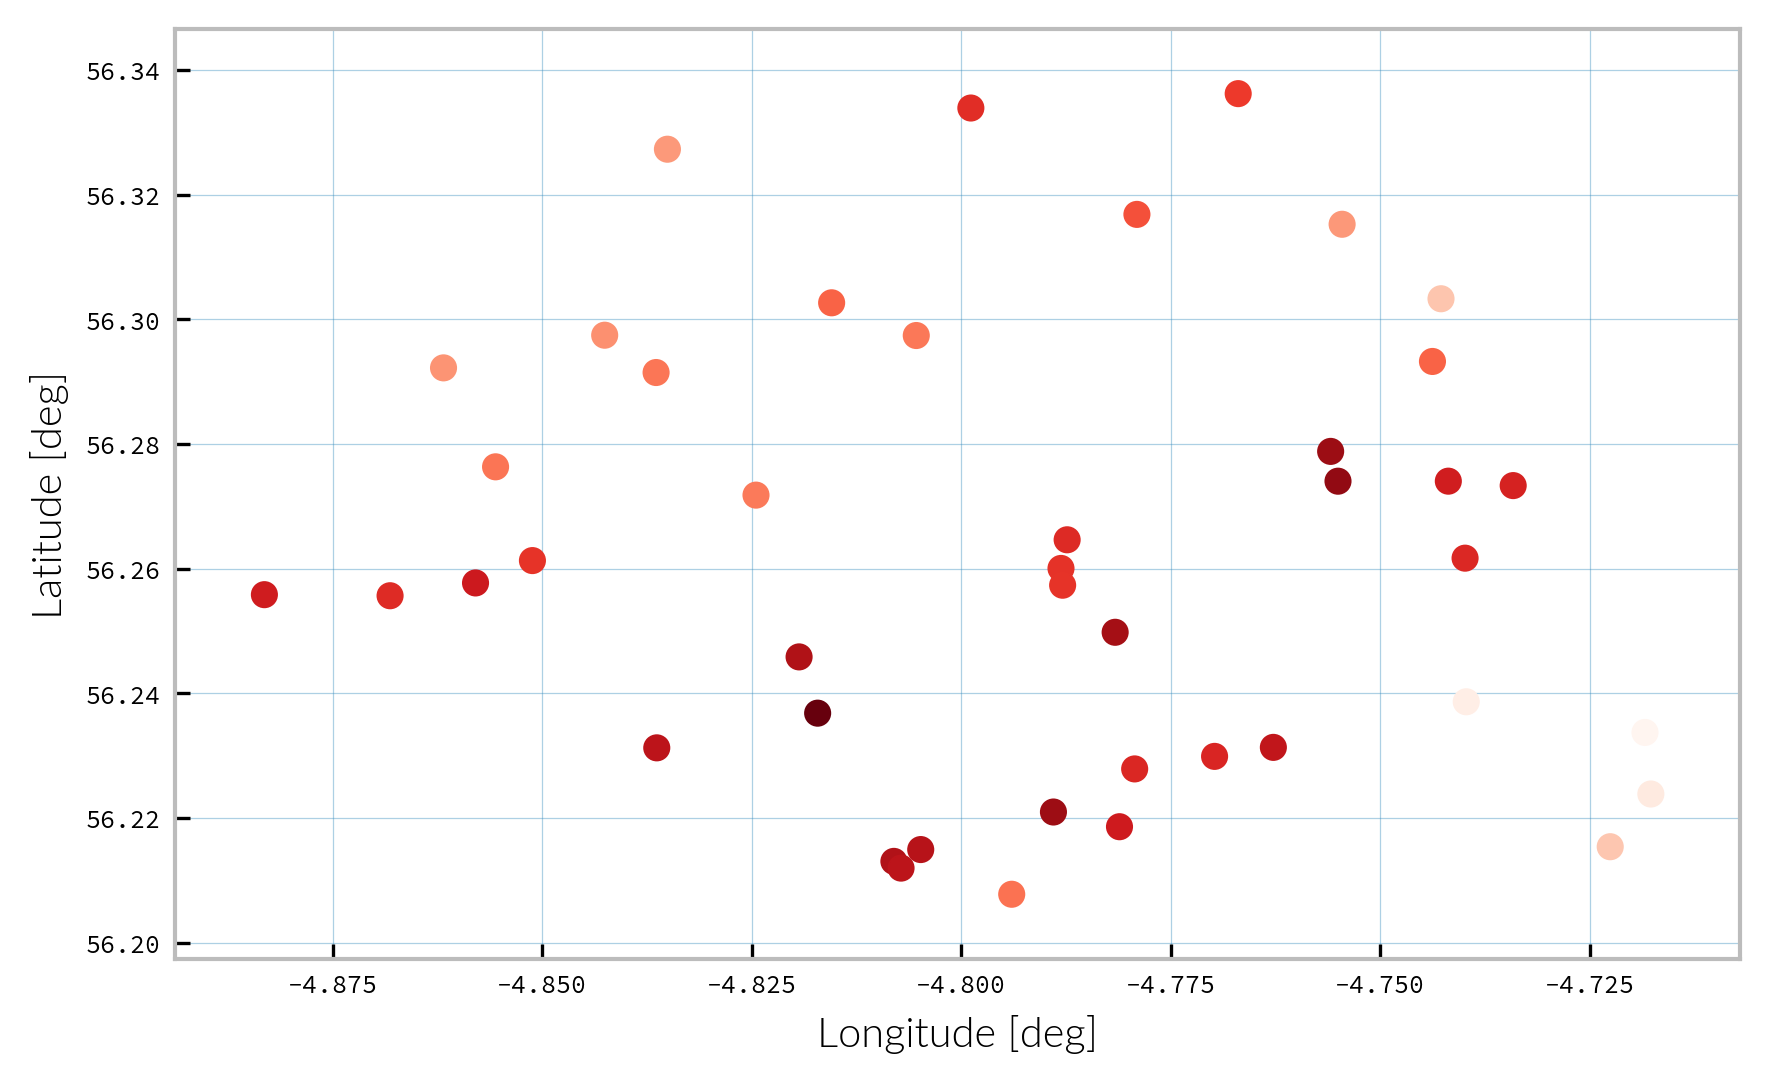

In [5]:
f, ax = plt.subplots(1,1, figsize=thesis.figsize, dpi=300)
ax.scatter(hills['lon'], hills['lat'], c=hills['height'], cmap='Reds')#, 'o', color='k')
#for i, txt in enumerate(n):
#plt.annotate(np.array(alps['height']), (np.array(alps['lat']), np.array(alps['lon'])))

ax.set_xlabel("Longitude [deg]")#, fontdict=lato)
ax.set_ylabel("Latitude [deg]")#, fontdict=lato)

thesis.thesisify(f);

In [177]:
import matplotlib.patheffects as path_effects
def plot_map(mu, var, hills, ax = None, contour_interval=10):
    new = False
    if not ax:
        new = True
        f, ax = plt.subplots(1,1, figsize=thesis.figsize, dpi=300)
    levels = np.arange(0, 1100, contour_interval)

    # np.mod(np.arange(len(levels)),5)!=0
    ax.contour(lons, lats, (mu.reshape(150,150)), levels[levels%50!=0], linewidths=.5, colors='#ff8959', alpha=0.75, zorder=1)

    CS = ax.contour(lons, lats, (mu.reshape(150,150)), levels[levels%50==0], linewidths=1, colors='#ff8959', alpha=0.75, zorder=1)
    c_labels = ax.clabel(CS, levels[levels%100==0], fontsize=5, inline=1, fmt="%.0f")



    for label in c_labels:
        label.set_font_properties(thesis.ticks_font)

    #ax.imshow(mu.reshape(150,150), extent=[lons.min(), lons.max(), lats.min(), lats.max()], alpha=0.4, vmin=-200, vmax=1100,
    #          cmap='terrain', origin='lower')
    ax.plot(hills['lon'], hills['lat'], 'o', markerfacecolor='k', markeredgecolor='w', zorder=98, markersize=3)
    
    if new:
        for hill in hills.iterrows():
            text = ax.text(0.0035+hill[1]['lon'], hill[1]['lat']-0.0015, int(hill[1]['height']), 
                           fontsize=4, zorder=99, fontdict=thesis.ssp_legend)
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                               path_effects.Normal()])
            if hill[1]['height'] > 880:
                text = ax.text(0.0035+hill[1]['lon'], hill[1]['lat']+0.001, hill[1]['name'], 
                               fontsize=5, fontdict=thesis.lato, zorder=100)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])
        #plt.colorbar()


        ax.set_xlabel("Longitude [deg]")
        ax.set_ylabel("Latitude [deg]")
        
    #if not new:
    #    ax.set_yticks(ax.get_ytick_labels()[1:-1])

    if new:
        thesis.thesisify(f);

        f.tight_layout()
        return f
    else:
        return ax
#f.savefig("../../figures/gp/arrochar-alps.pdf")

In [97]:
lons = np.linspace(-4.85, -4.70, 20)
lats = np.linspace(56.20, 56.28, 20)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [120]:
with pm.Model() as model:
    
    amp = pm.Normal("amplitude", 1, 1)
    ls = [0.012, 0.012] #
    ls = pm.Normal("metric", mu=[0.012, 0.012], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.RatQuad(2, ls=ls, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)

In [121]:
with model:
    mp = pm.find_MAP()

logp = -17,796, ||grad|| = 746.49: 100%|██████████| 86/86 [00:00<00:00, 296.83it/s]          


In [122]:
lons = np.linspace(-4.9, -4.70, 150)
lats = np.linspace(56.20, 56.35, 150)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [123]:
with model:
    mu_rq, var_rq = gp.predict(points, point=mp, diag=True)
    sd_rq = np.sqrt(var_rq)

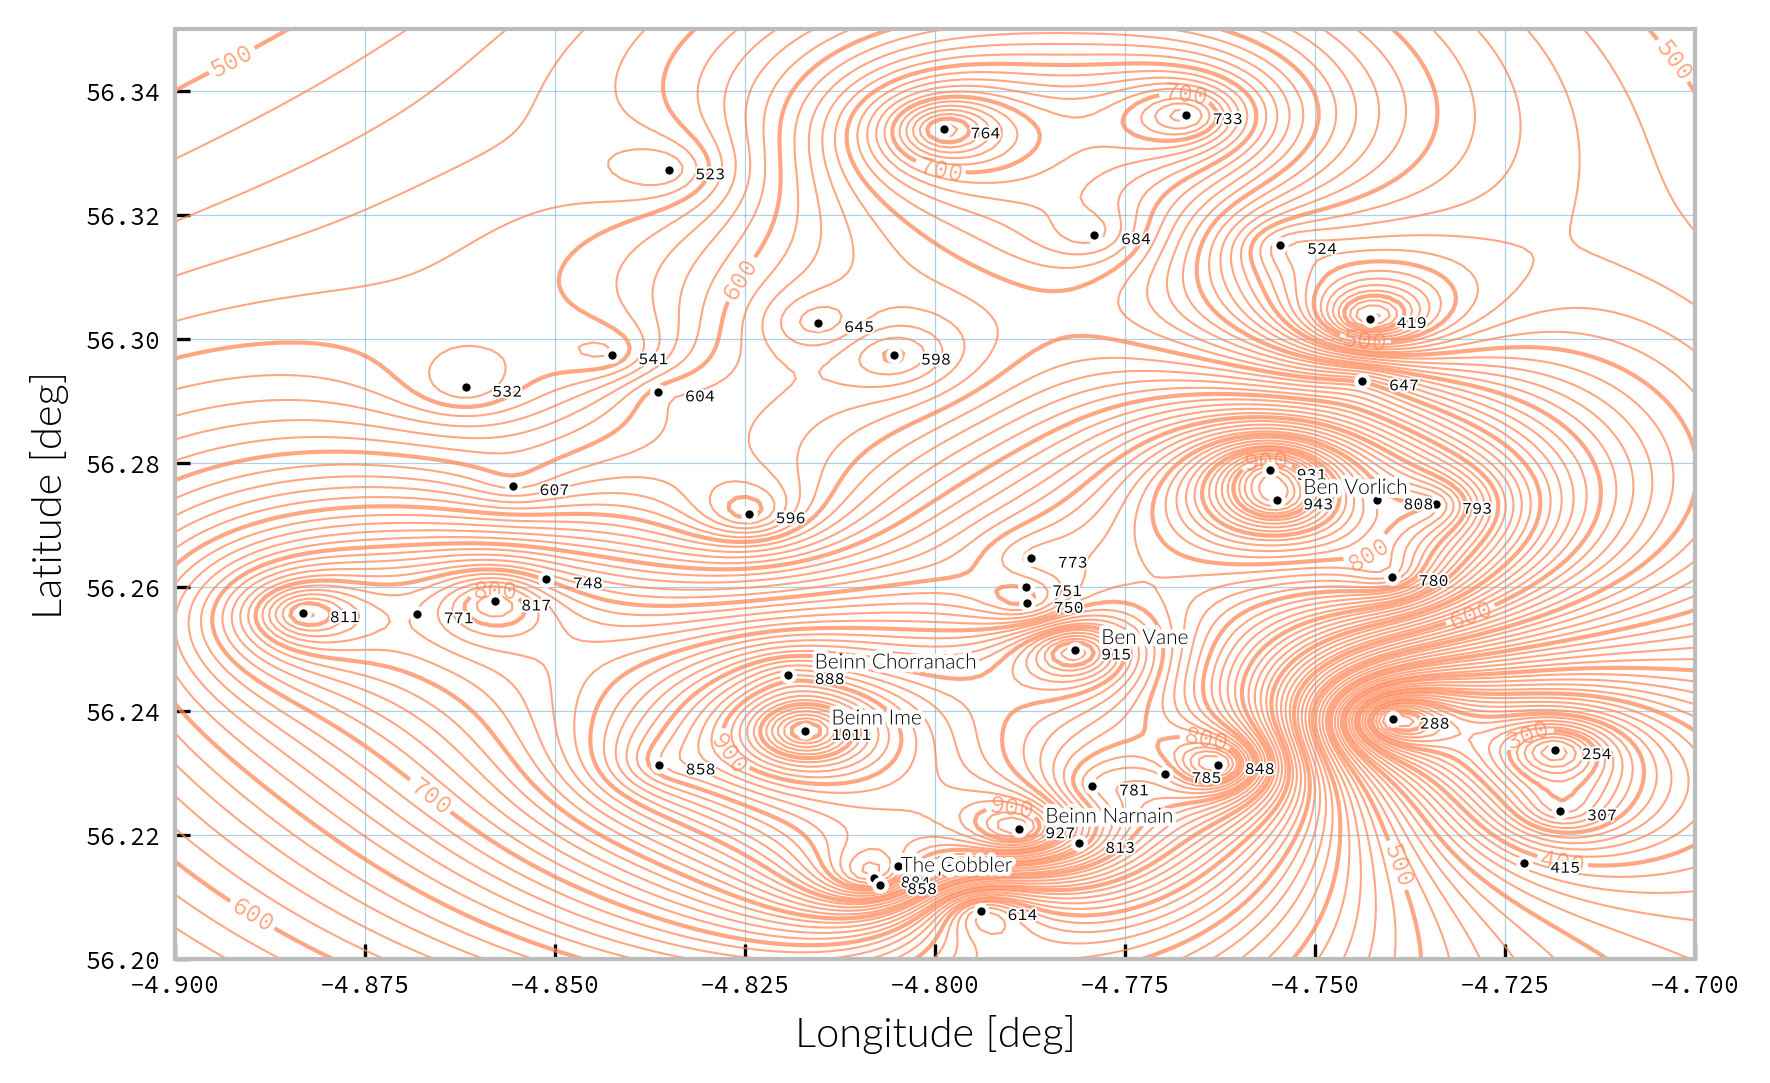

In [170]:
f = plot_map(mu_rq, sd_rq, hills, contour_interval=10);
f.savefig("../../figures/gp/arrochar-alps.pdf")

In [105]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.HalfCauchy("metric", [0.012, 0.012], shape=2)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=ls) #, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)
    mp = pm.find_MAP()

with model:
    mu_eq, var_eq = gp.predict(points, point=mp, diag=True)
    sd_eq = np.sqrt(var)

logp = -40,315, ||grad|| = 0.85623: 100%|██████████| 67/67 [00:00<00:00, 396.68it/s]  


In [106]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.HalfCauchy("metric", [5,5], shape=2)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.Exponential(2, ls_inv=ls) #, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)
    mp = pm.find_MAP()

with model:
    mu_ex, var_ex = gp.predict(points, point=mp, diag=True)
    sd_ex = np.sqrt(var)

logp = -20,053, ||grad|| = 20.196: 100%|██████████| 45/45 [00:00<00:00, 323.25it/s]  


In [112]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.HalfCauchy("metric", [1,1], shape=2)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.Matern52(2, ls=ls) #, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)
    mp = pm.find_MAP()

with model:
    mu_mat, var_mat = gp.predict(points, point=mp, diag=True)
    sd_mat = np.sqrt(var_mat)

logp = -31,154, ||grad|| = 0.0011969: 100%|██████████| 85/85 [00:00<00:00, 387.88it/s]  


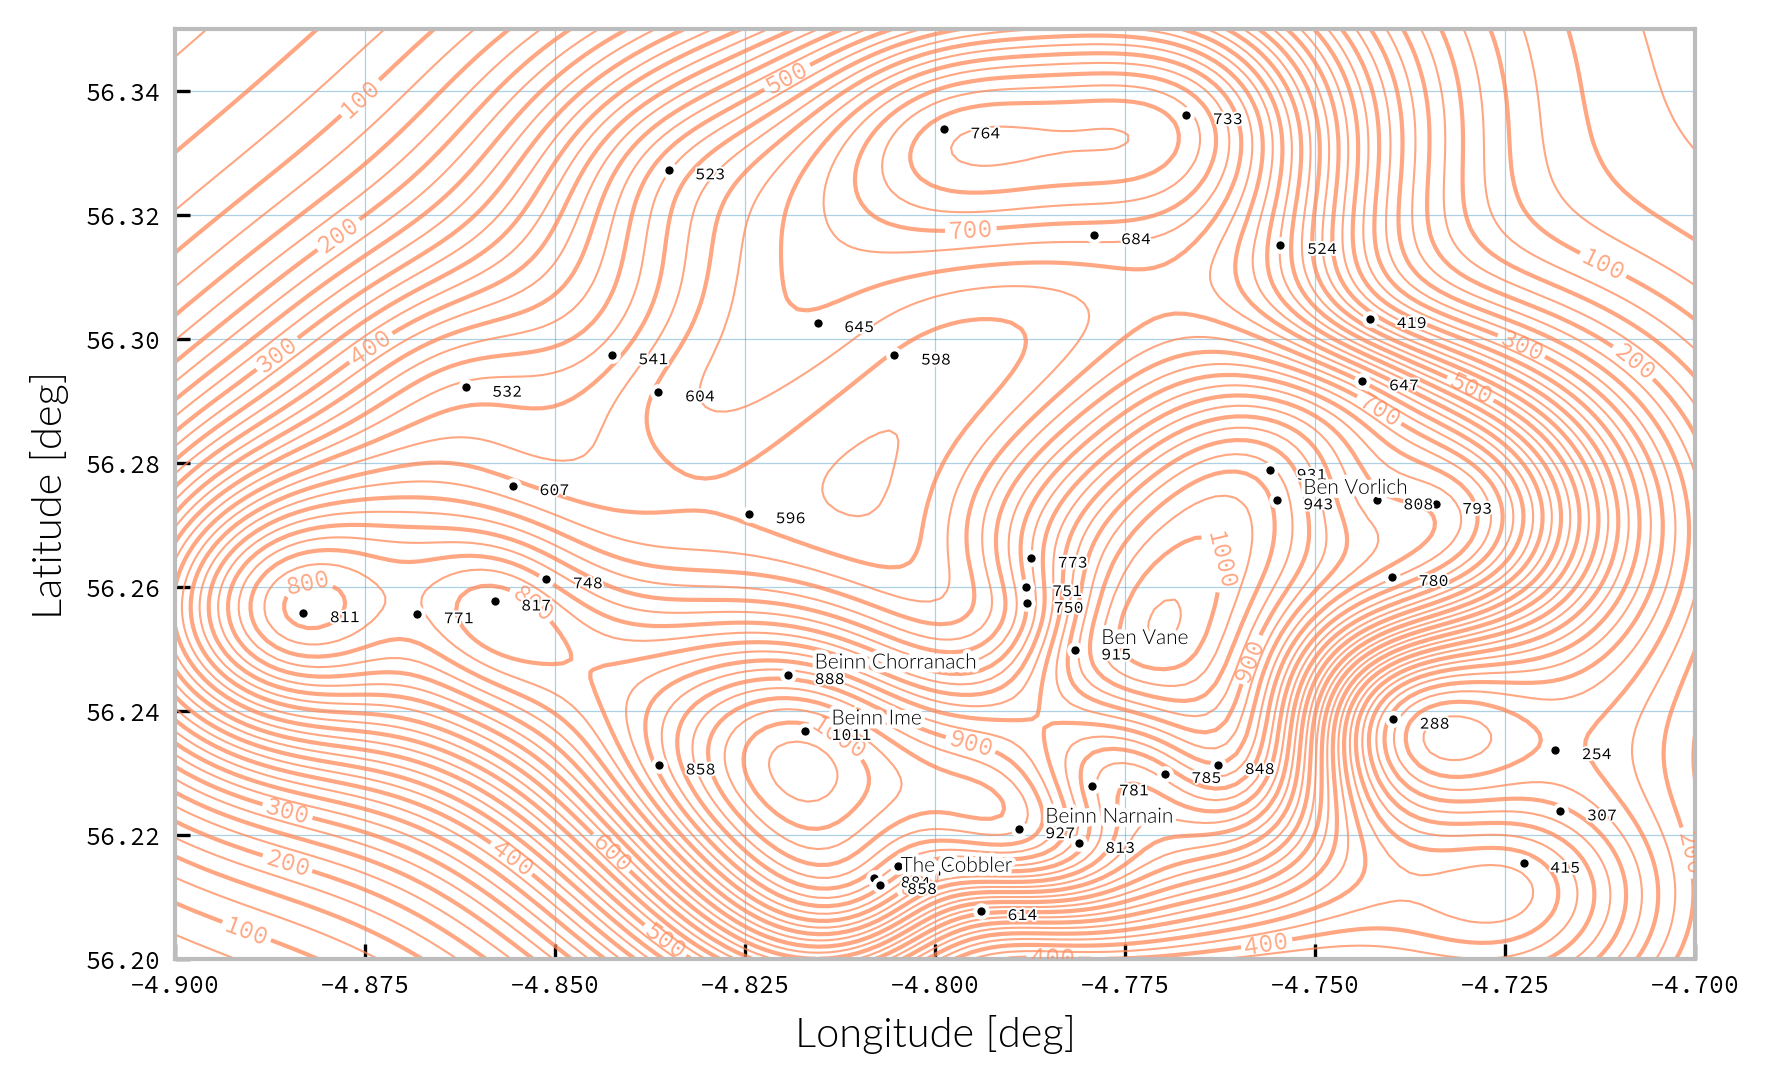

In [147]:
plot_map(mu_mat, sd, hills, contour_interval=25);

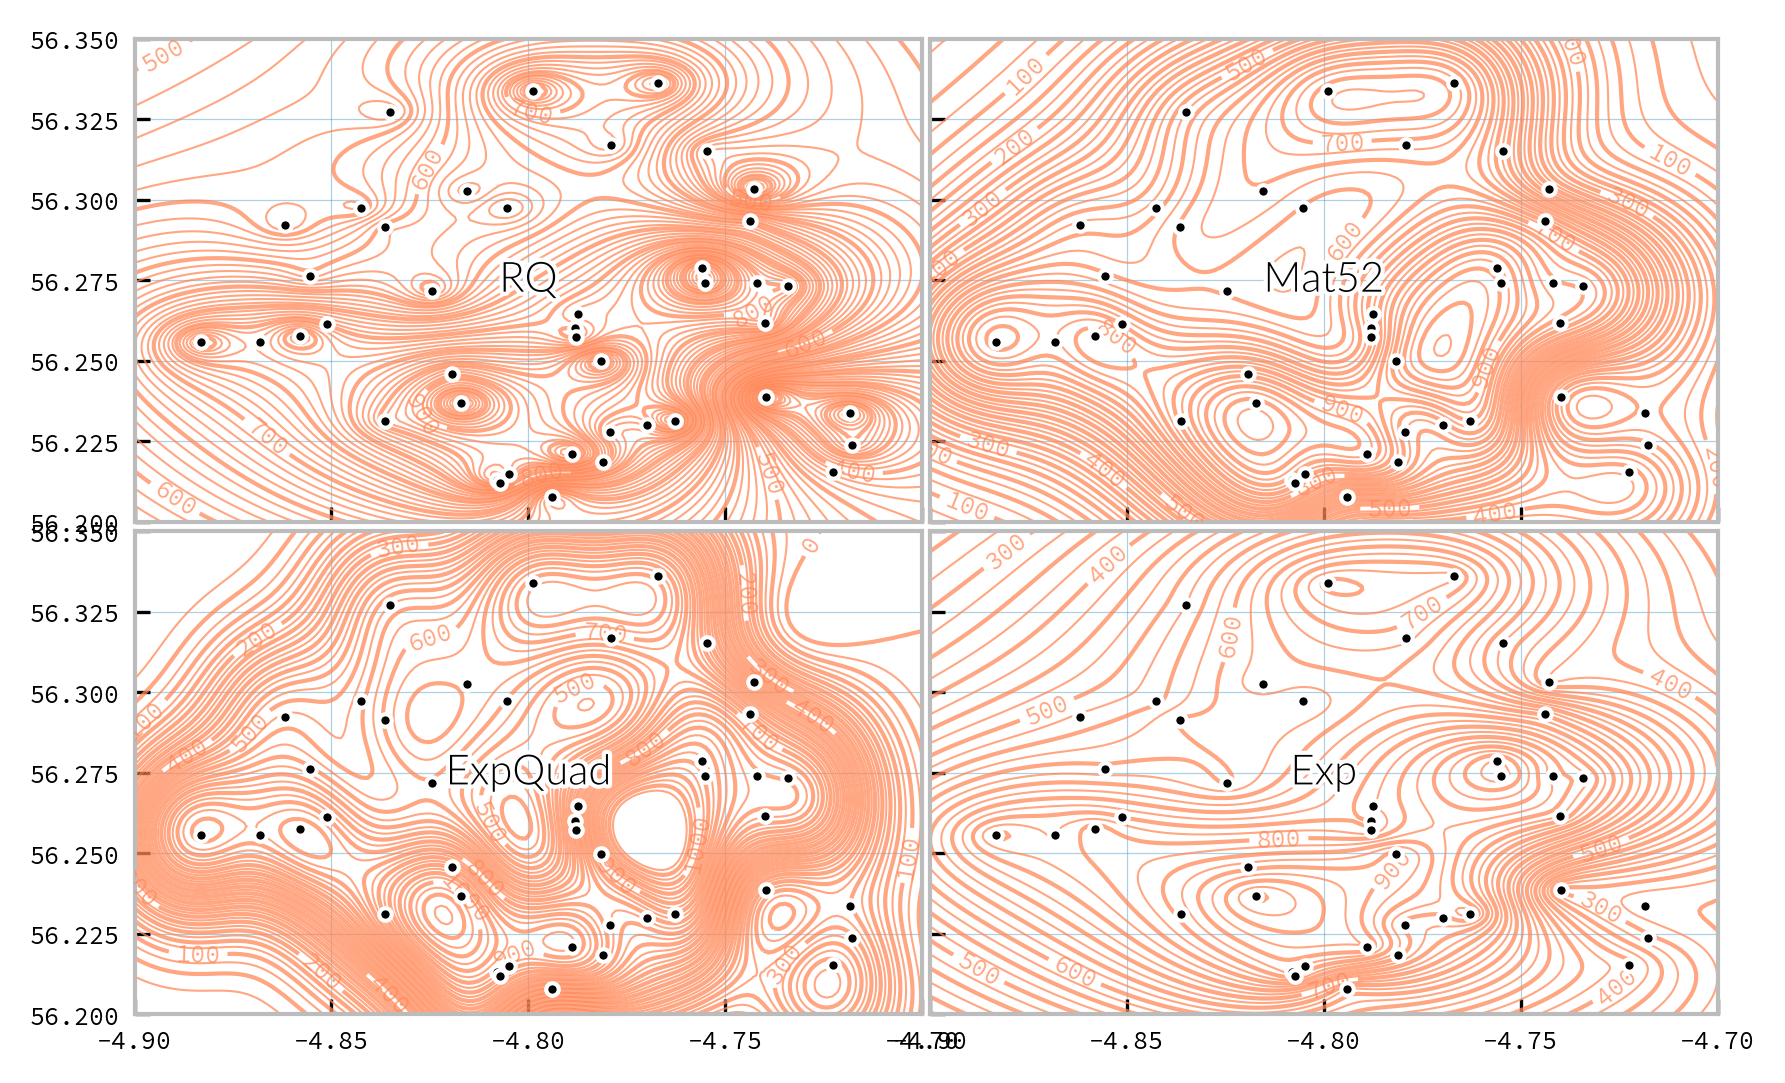

In [178]:
f, ax = plt.subplots(2,2, dpi=300, sharex=True, sharey=True);
plot_map(mu_rq, sd_rq, hills, ax[0,0]);
text = ax[0, 0].text(-4.80, 56.275, "RQ", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

plot_map(mu_mat, sd_mat, hills, ax[0,1], contour_interval=25);
text = ax[0, 1].text(-4.80, 56.275, "Mat52", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

plot_map(mu_eq, sd_eq, hills, ax[1,0], contour_interval=25);
text = ax[1,0].text(-4.80, 56.275, "ExpQuad", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])


plot_map(mu_ex, sd_ex, hills, ax[1,1], contour_interval=25);
text = ax[1,1].text(-4.80, 56.275, "Exp", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

thesis.thesisify(f);
f.subplots_adjust(wspace=0.01, hspace=0.02)

#f.savefig("../../figures/gp/arrochar-kernels.pdf")

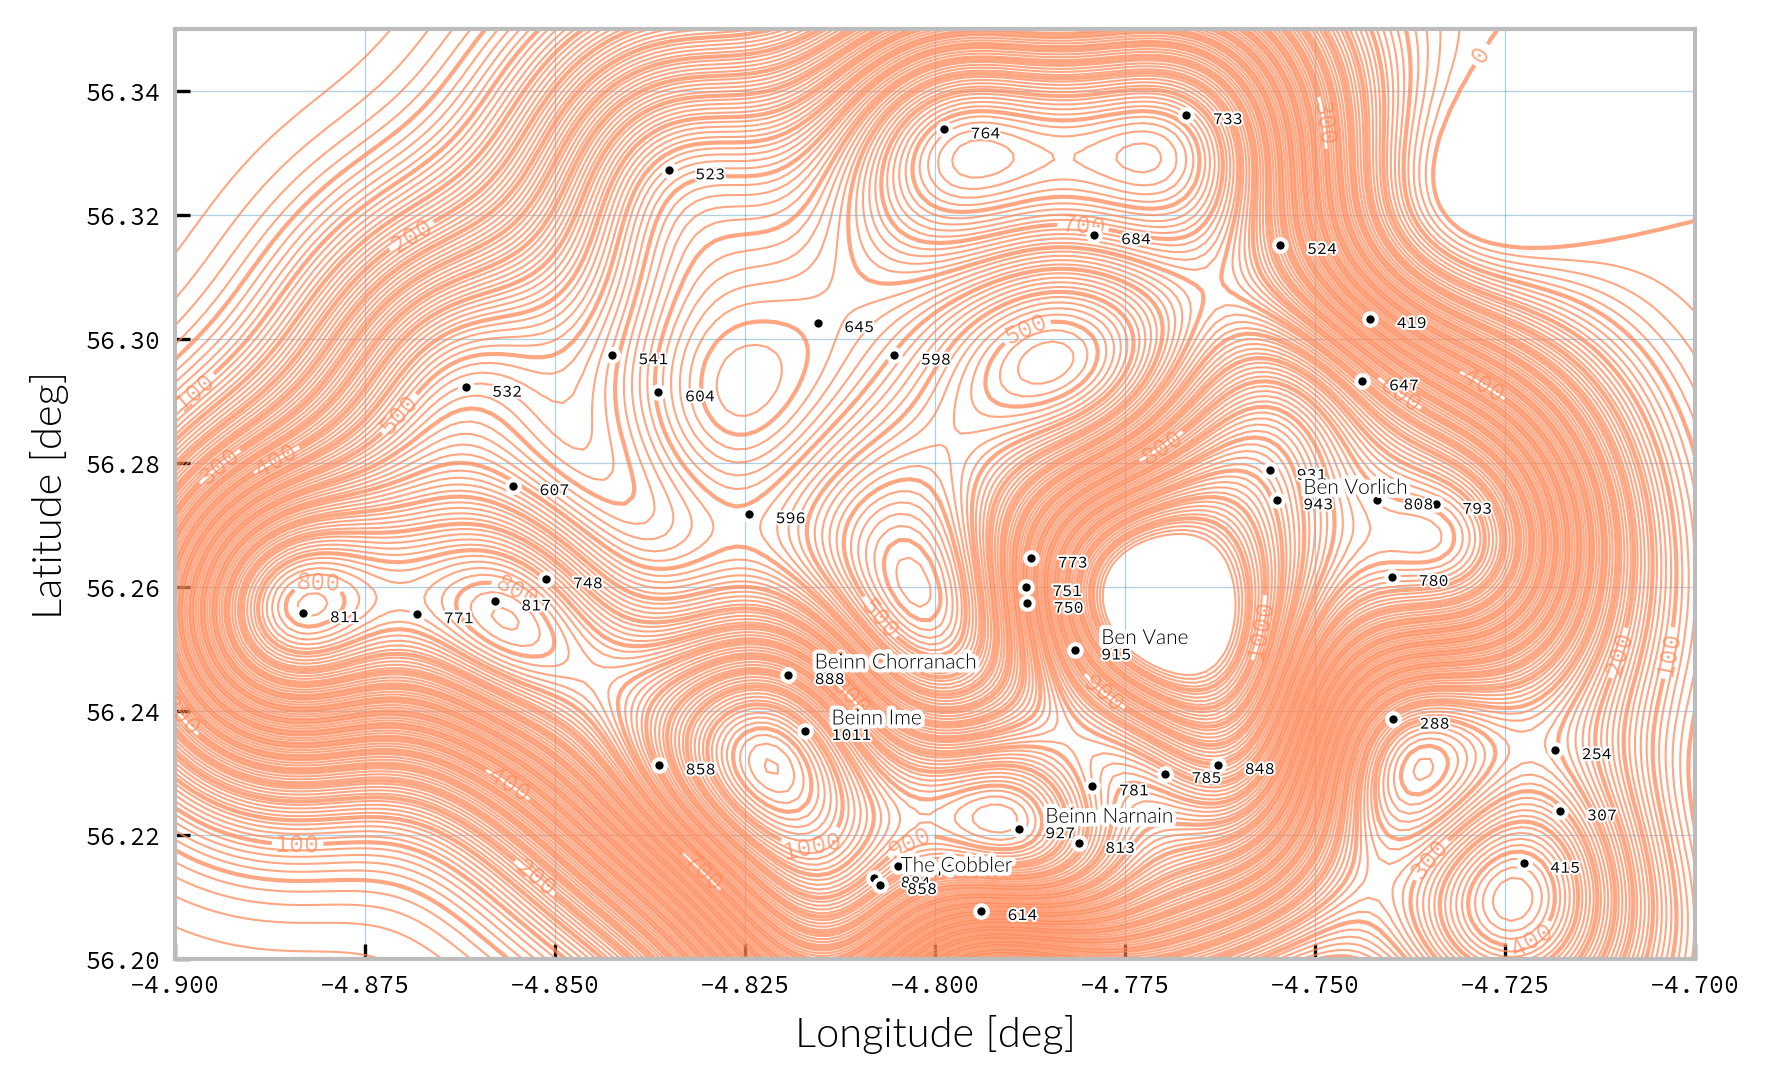

In [52]:
plot_map(mu, sd, hills);
f.savefig("../../figures/gp/arrochar-alps-quadexponential.pdf")